# Bilateral Bargaining: Evaluation of the Experiments

In [1]:
import os
import sys
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
import re
import pandas as pd

# pylint: disable=wrong-import-position
sys.path.append(os.path.realpath('.'))
sys.path.append(os.path.join(os.path.expanduser('~'), 'projects/bnelearn'))

from bnelearn.util.metrics import ALIASES_LATEX
from scripts.utils import *

COLORS = (0/255.,150/255.,196/255.),(248/255.,118/255.,109/255.),(150/255.,120/255.,170/255.),(255/255.,215/255.,130/255.)

log_root_dir = os.path.join(os.path.expanduser('~'), 'bnelearn','experiments','bargaining_paper_results')

In [ ]:
### EXP-1 BB 1/2-DA & VCG -----------------------------------------------------
path = log_root_dir + '/exp-1-k-da-truthful-vcg-random'

path_kDA = path + '/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/1b1s/'
path_kDA += os.listdir(path_kDA)[0]
path_VCG = path + '/double_auction/single_item/vcg/uniform/symmetric/risk_1.0/1b1s/'
path_VCG += os.listdir(path_VCG)[0] 

exps = dict()
exps['$0.5$-DA'] = path_kDA + '/aggregate_log.csv'
exps['VCG'] = path_VCG + '/aggregate_log.csv'

with open(path_kDA + '/experiment_configurations.json') as json_file:
    running = json.load(json_file)['running']
    n_runs, n_epochs = running['n_runs'], running['n_epochs']

csv_to_tex(
    experiments = exps,
    name = os.curdir + '/exp-1_table.tex',
    metrics = ['eval_vs_bne/L_2', 'eval_vs_bne/epsilon_relative', 'eval/estimated_relative_ex_ante_util_loss'],
    caption = f"Mean and standard deviation over {'ten' if n_runs==10 else n_runs} runs of {int(n_epochs/1000)},000 iterations of the learning metrics for the average mechanism, i.e., the 1/2-double auction.",
    symmetric = False,
    label = 'tab:exp-1_table'
)

In [2]:
def get_value_and_std_from_df_entry(df_entry: str) -> float:
    list_of_numbers = re.findall('\d+', df_entry)
    return float(list_of_numbers[0] + '.' + list_of_numbers[1]), float(list_of_numbers[2] + '.' + list_of_numbers[3])

In [ ]:
### EXP-2 risk experiments ----------------------------------------------------
path = log_root_dir + '/exp-9_experiment/double_auction/single_item/'
exps = dict()
metric = 'metrics/normalized_profits_from_trade'
fig = plt.figure(figsize=(4.5, 4))
plt.style.use('ggplot')

for j, (payment_rule, p_path) in enumerate(zip(['average double auction', 'VCG double auction'], ['k_price/0.5/uniform/symmetric', 'vcg/uniform/symmetric'])):  # 'vcg
    for risk_str in sorted(next(os.walk(path + p_path))[1]):
        exps[float(risk_str[5:])] = get_sub_path(path + p_path + '/' + risk_str, 2) + '/aggregate_log.csv'
        risks = np.array(list(exps.keys()))
        means = np.zeros_like(risks)
        stds = np.zeros_like(risks)
        for i, (risk, exp) in enumerate(exps.items()):
            df = single_exp_logs_to_df(path=exp, with_stddev=True, metrics=[metric])
            means[i], stds[i] = get_value_and_std_from_df_entry(df[metric][0])

    plt.plot(risks, means, label=payment_rule, color=COLORS[j])
    plt.fill_between(risks, means-stds, means+stds, color=COLORS[j], alpha=.3)
plt.xlabel('risk $\\rho$'); plt.ylabel('efficiency')
plt.ylim([0.77, 1.03])
plt.legend(loc='lower left')
plt.title("NPGA")  
plt.tight_layout()
plt.savefig(os.curdir + '/exp-9_figure.pdf')
plt.show()

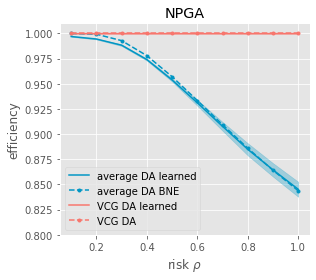

In [40]:
# ### EXP-2 risk experiments ----------------------------------------------------
# TODO: Back up plot from dataframe
# path = log_root_dir + '/exp-9_experiment/double_auction/single_item/'
# df = pd.read_csv('/home/kohring/bnelearn/experiments/eff/df.csv')
# plt.style.use('ggplot')
# fig = plt.figure(figsize=(4.5, 4))
# risks = [i/10 for i in range(1, 11)]

# for j, (payment_rule, p_path) in enumerate(zip(['average DA', 'VCG DA'], ['k_price', 'vcg'])):
#     means, stds = np.zeros_like(risks), np.zeros_like(risks)
#     for i, risk in enumerate(risks):
#         vals = df[(df['price'] == p_path) & (df['risk'] == risk)]
#         means[i], stds[i] = vals['mean'].item(), vals['std'].item()
#     plt.plot(risks, means, label=payment_rule + ' learned', color=COLORS[j])
#     if p_path == 'k_price':
#         plt.plot(risks, np.array([0.99999929, 0.99927383, 0.99287405, 0.97795542, 0.95707949,
# 0.93340804, 0.90937204, 0.88602273, 0.86404628, 0.84373747]), '--.', label=payment_rule + ' BNE', color=COLORS[j])
#     else:
#         plt.plot(risks, np.ones_like(risks), '--.', label=payment_rule, color=COLORS[j])
#     plt.fill_between(risks, means-stds, means+stds, color=COLORS[j], alpha=.3)
# plt.xlabel('risk $\\rho$'); plt.ylabel('efficiency')
# plt.ylim([0.8, 1.01])
# plt.legend(loc='lower left')
# plt.title("NPGA")  
# plt.tight_layout()
# plt.savefig(os.curdir + '/exp-2_figure.pdf')
# plt.show()

In [41]:
# Experiment 3 - Symmetric Equilibrium Initialization
path = path = log_root_dir + '/exp-3_sym_BNE/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/1b1s/'
metrics_names = ["eval_vs_bne/epsilon_relative", "eval_vs_bne/L_2"]
metrics_names_latex = ["$\mathcal{L}^\text{BNE{1}}$", "$L_2^\text{BNE{1}}$"]
plot_metric_names_latex = ["$\mathcal{L}$", "$L_2$"]
bidders = ['buyer', 'seller']
exp_names = sorted(os.listdir(path))
metrics = np.zeros((2, 2, len(metrics_names), len(exp_names)))

g_05s = np.zeros(len(exp_names))
for i, exp_name in enumerate(exp_names):
    with open(path + exp_name + '/experiment_configurations.json') as json_file:
        g_05s[i] = float(json.load(json_file)['setting']['pretrain_transform'])
    df = single_exp_logs_to_df(path=path + exp_name + '/aggregate_log.csv',
                               with_stddev=True, metrics=metrics_names)
    # buyer
    for bidder_id in range(len(bidders)):
        for metric_id in range(len(metrics_names)):
            mean, std = get_value_and_std_from_df_entry(df[metrics_names_latex[metric_id]][bidder_id])
            metrics[bidder_id, 0, metric_id, i] = mean
            metrics[bidder_id, 1, metric_id, i] = std


metrics[metrics != metrics] = np.inf
colors = [[(0/255.,150/255.,196/255.), (248/255.,118/255.,109/255.)],
          [(150/255.,120/255.,170/255.), (255/255.,215/255.,130/255.)]]
linestyles = [["-", "--"], ["-.", ":"]]

plt.figure()
plt.style.use('ggplot')
for bidder_id, bidder in enumerate(bidders):
    for metric_name_id, metric_name in enumerate(plot_metric_names_latex):
        plt.plot(g_05s, metrics[bidder_id, 0, metric_name_id],
                 label=metric_name + ' ' + bidder, color=colors[bidder_id][metric_name_id],
                 linestyle=linestyles[bidder_id][metric_name_id])
        plt.fill_between(
            g_05s,
            metrics[bidder_id, 0, metric_name_id] - metrics[bidder_id, 1, metric_name_id],
            metrics[bidder_id, 0, metric_name_id] + metrics[bidder_id, 1, metric_name_id],
            alpha=0.4,
            color=colors[bidder_id][metric_name_id])
plt.plot([3./8., 3./8.], [0, 1], linestyle=(0, (1, 1)), color='grey', label=r'linear BNE')
plt.xlabel(r'$g_{sym}$ value')
plt.ylabel('difference to linear BNE')
plt.xlim([g_05s[0], g_05s[-1]]); plt.ylim([0, .3])
plt.legend(loc='upper left')
plt.savefig(os.curdir + '/exp-3_figure.pdf')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/kohring/bnelearn/experiments/bargaining_paper_results/exp-3_sym_BNE/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/1b1s/'

In [ ]:
## EXP-3 custom pretraining experiments - Each pretrained BNE individually --------------------------------------
path = log_root_dir + '/exp-3_sym_BNE/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/1b1s/'
metrics_names = ['eval_vs_bne/L_2', 'eval_vs_bne/epsilon_relative', 'eval/estimated_relative_ex_ante_util_loss']
bne_ids = [1, 4]
metric_names_latex = ['pretrain_transform', 'bidder']
for bne_id in bne_ids:
    metric_names_latex.extend(["$\mathcal{L}^\text{BNE{%s}}$" % str(bne_id), "$L_2^\text{BNE{%s}}$" % bne_id])

exp_names = sorted(os.listdir(path))
experiments = {}
df_list = []
for i, exp_name in enumerate(exp_names):
    with open(path + exp_name + '/experiment_configurations.json') as json_file:
        g_05 = float(json.load(json_file)['setting']['pretrain_transform'])
        g_05 = "{:.2f}".format(g_05)
    df = single_exp_logs_to_df(path=path + exp_name + '/aggregate_log.csv',
                               with_stddev=True, metrics=metrics_names)
    df.insert(0, 'pretrain_transform', [g_05, None])
    df_list.append(df)
combined_df = pd.concat(df_list)
sliced_df = combined_df[metric_names_latex]

df_to_tex(sliced_df, name='exp-3_table_pretrain_transforms.tex',
        label='tab:exp-3_table_pretrain_transform',
        caption='Mean and standard deviation of experiments over ten runs' \
        + ' each for a different pretrained non-optimal Equilibrium.')

In [ ]:
## EXP-3 custom pretraining experiments - Aggregated over all pretrained BNEs -------------------------------------
path_experiments = log_root_dir + '/exp-3_sym_BNE/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/1b1s/'
columns_to_drop = ['wall_time', 'run']
metric_names = ['eval_vs_bne/L_2_bne1', 'eval_vs_bne/epsilon_relative_bne1']
latex_col_names = ["$L_2$", "$\mathcal{L}$"]
aggregate_cols = ['tag', 'subrun']

row_values_to_filter = {
    'tag': metric_names,
    'epoch': [2000]}

# get all data (this may take some time)
df_dict = get_data_frames_from_multiple_experiments(path_experiments)
filtered_df_dict = {
    key: filter_full_results_df(value, row_values_to_filter, columns_to_drop) for key, value in df_dict.items()
}
concatenated_df = concatenate_dfs_from_dict(filtered_df_dict)
df = concatenated_df.groupby(
        aggregate_cols, as_index=False
    ).agg({'value': ['mean', 'std']})
df.columns = ['metric', 'bidder', 'mean', 'std']
df_mean_std = combine_mean_stddv_into_single_column(df, precision=4)
unstacked_df = df_unstack_values_by_tag_and_index(df_mean_std)
unstacked_df = unstacked_df[metric_names]  # reorder the columns to the given order
unstacked_df.rename({metric_name: latex_name for metric_name, latex_name in zip(metric_names, latex_col_names)}, inplace=True, axis=1)
# store as table
df_to_tex(unstacked_df, name='exp-3_table_all_runs_aggregated_epoch_2000.tex', print_index=True,
        print_index_names=True,
        label='tab:exp-3_table_pretrain_transform_aggregated',
        caption='Mean and standard deviation of experiments for the average mechanism, i.e., the 1/2-double auction, over twelve different' \
        + ' pretrained non-optimal Equilibria each run with ten different seeds.')


In [ ]:
# Combine Exp-1 and Exp-3 into a single Table (run cell: ## EXP-3 custom pretraining experiments - Aggregated over all pretrained BNEs) with selective random VCG results
path = log_root_dir + '/exp-1-k-da-truthful-vcg-random'

path_kDA = path + '/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/1b1s/'
path_kDA += os.listdir(path_kDA)[0]

path_VCG = log_root_dir + '/exp-1-k-da-truthful-vcg-random/double_auction/single_item/vcg/uniform/symmetric/risk_1.0/1b1s/'

metrics_names = ["eval_vs_bne/epsilon_relative", "eval_vs_bne/L_2"]
metrics_names_latex = ["$\mathcal{L}^\text{BNE{1}}$", "$L_2^\text{BNE{1}}$"]
plot_metric_names_latex = ["$\mathcal{L}$", "$L_2$"]

# #### k-price rule truthful init ##### #
df_kDA = single_exp_logs_to_df(path=path_kDA + '/aggregate_log.csv',
                               with_stddev=True, metrics=metrics_names, precision=4)
names_to_keep = [name for name in list(df_kDA) if any([name in metric_name for metric_name in metrics_names_latex])]
names_to_keep.insert(0, "bidder")
df_kDA = df_kDA.drop([name for name in df_kDA.columns if name not in names_to_keep], axis=1)
df_kDA.columns = ["bidder", "$L_2$", "$\mathcal{L}$"]
df_kDA.insert(0, "initialization", ["truthful", np.nan])
df_kDA.insert(0, "auction", ["$0.5$-DA", np.nan])

# #### VCG price rule #### #
columns_to_drop = ['wall_time']
metric_names = ['eval_vs_bne/L_2', 'eval_vs_bne/epsilon_relative']
latex_col_names = ["$L_2$", "$\mathcal{L}$"]
aggregate_cols = ['tag', 'subrun']
succeeded_runs = [  # These are the runs that did not lead to no-trading strategies!
    '03 12:04:52 3',
    '04 12:25:15 4',
    '05 12:45:22 5',
    '06 13:05:24 6',
    '07 13:25:37 7',
    '08 13:45:55 8',
    '10 14:26:18 10',
    '13 15:27:51 13',
    '17 16:49:55 17'
]

row_values_to_filter = {
    'tag': metric_names,
    'epoch': [1999],
    'run': succeeded_runs}

# get all data (this may take some time)
df_dict = get_data_frames_from_multiple_experiments(path_VCG)
filtered_df_dict = {
    key: filter_full_results_df(value, row_values_to_filter, columns_to_drop) for key, value in df_dict.items()
}
concatenated_df = concatenate_dfs_from_dict(filtered_df_dict)
df = concatenated_df.groupby(
        aggregate_cols, as_index=False
    ).agg({'value': ['mean', 'std']})
df.columns = ['metric', 'bidder', 'mean', 'std']
df_mean_std = combine_mean_stddv_into_single_column(df, precision=4)
df_VCG = df_unstack_values_by_tag_and_index(df_mean_std)
df_VCG = df_VCG[metric_names]  # reorder the columns to the given order
df_VCG.rename({metric_name: latex_name for metric_name, latex_name in zip(metric_names, latex_col_names)}, inplace=True, axis=1)
df_VCG.insert(0, "initialization", ["selective random", np.nan])
df_VCG.insert(0, "auction", ["VCG", np.nan])

# #### k-price rule symmetric BNE init ##### #
unstacked_df['bidder'] = unstacked_df.index
cols = unstacked_df.columns.to_list()
cols = cols[-1:] + cols[:-1]
unstacked_df = unstacked_df[cols]
unstacked_df.insert(0, "initialization", ["symmetric BNE", np.nan])
unstacked_df.insert(0, "auction", ["$0.5$-DA", np.nan])

concat_df = pd.concat([df_kDA, unstacked_df, df_VCG], ignore_index=True)

df_to_tex(concat_df, name='exp-1_and_3_table.tex', print_index=False,
        print_index_names=False,
        label='tab:exp-1_3_table_aggregated',
        caption='Mean and standard deviation for different initialization procedures for the 1/2-double and VCG auction for NPGA.' \
            + ' The truthful initialization is the average over ten different seeds. The symmetric BNE case averages over twelve' \
            + ' different experiments with a pretraining on different symmetric BNE strategies for 10000 steps each run with' \
            + ' ten different seeds. The selective random initialization is a random initialization excluding those runs where one' \
            + ' starts with non-trading strategies. The training period was 2000 epochs for all runs.')

In [ ]:
## EXP-3 custom pretraining experiments - Report error to originally pretrained BNE strategies -------------------------------------
path_experiments = log_root_dir + '/exp-3_sym_BNE/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/1b1s/'
columns_to_drop = ['wall_time', 'run']
metric_names = ['eval_vs_bne/L_2_bne4', 'eval_vs_bne/epsilon_relative_bne4']
# BNE 4 is the equilibrium it was pretrained on
latex_col_names = ["$L_2$", "$\mathcal{L}$"]
aggregate_cols = ['tag', 'subrun']

row_values_to_filter = {
    'tag': metric_names,
    'epoch': [2000]}

# get all data (this may take some time)
df_dict = get_data_frames_from_multiple_experiments(path_experiments)
filtered_df_dict = {
    key: filter_full_results_df(value, row_values_to_filter, columns_to_drop) for key, value in df_dict.items()
}
concatenated_df = concatenate_dfs_from_dict(filtered_df_dict)
df = concatenated_df.groupby(
        aggregate_cols, as_index=False
    ).agg({'value': ['mean', 'std']})
df.columns = ['metric', 'bidder', 'mean', 'std']
df_mean_std = combine_mean_stddv_into_single_column(df, precision=4)
unstacked_df = df_unstack_values_by_tag_and_index(df_mean_std)
unstacked_df = unstacked_df[metric_names]  # reorder the columns to the given order
unstacked_df.rename({metric_name: latex_name for metric_name, latex_name in zip(metric_names, latex_col_names)}, inplace=True, axis=1)
# store as table
df_to_tex(unstacked_df, name='exp-3_final_distance_to_pretrained_equilibria.tex', print_index=True,
        print_index_names=True,
        label='tab:exp-3_final_distance_to_pretrained_equilibria',
        caption='Mean and standard deviation of experiments for the 1/2-double auction over twelve different' \
        + ' pretrained non-optimal Equilibria each run with ten different seeds. The reported losses are measured to' \
            + ' the pretrained BNE strategies after 2000 epochs of training.')

In [ ]:
### EXP-4 Gaussian Prior 1/2-DA & VCG -----------------------------------------------------
path = log_root_dir + '/exp-4_experiment'

path_kDA = path + '/double_auction/single_item/k_price/0.5/normal/symmetric/risk_1.0/1b1s/'
path_kDA += os.listdir(path_kDA)[0]
path_VCG = path + '/double_auction/single_item/vcg/normal/symmetric/risk_1.0/1b1s/'
path_VCG += os.listdir(path_VCG)[0] 

exps = dict()
exps['$0.5$-DA'] = path_kDA + '/aggregate_log.csv'
exps['VCG'] = path_VCG + '/aggregate_log.csv'

with open(path_kDA + '/experiment_configurations.json') as json_file:
    running = json.load(json_file)['running']
    n_runs, n_epochs = running['n_runs'], running['n_epochs']

csv_to_tex(
    experiments = exps,
    name = os.curdir + '/exp-4_table_random_init.tex',
    metrics = ['eval_vs_bne/L_2', 'eval_vs_bne/epsilon_relative', 'eval/estimated_relative_ex_ante_util_loss'],
    caption = f"Mean and standard deviation over {'ten' if n_runs==10 else n_runs} runs of {int(n_epochs/1000)},000 iterations of the learning metrics for the two most common mechanisms in the bilateral bargaining setup for a Gaussian prior with mean 15 and standard deviation 5. The strategies were initialized randomly.",
    symmetric = False,
    label = 'tab:exp-4_table'
)

In [ ]:
### EXP-5: several buyers, 1 seller -----------------------------------------------------
path_to_experiments = log_root_dir + '/'
experiment_names = [
    'exp-5_experiment', 'exp-5-2_experiment', 'exp-5-3_experiment'
]
auction_type = 'k_price'
experiment_name = 'exp_5_' + auction_type
save_name = '/' + experiment_name + '_table.tex'
label = 'tab:' + experiment_name
if auction_type == 'k_price':
    auction_path = '/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/'
    auction_latex_name = '$0.5$-DA'
elif auction_type == 'vcg':
    auction_path = '/double_auction/single_item/vcg/uniform/symmetric/risk_1.0/'
    auction_latex_name = 'VCG'
else:
    raise ValueError('No valid auction_type selected.')
exps = dict()
for k, experiment_name in enumerate(experiment_names):
    agent_dist_description = str(k+2) + 'b1s'
    full_experiment_path = path_to_experiments + experiment_name + auction_path + agent_dist_description + '/'
    full_experiment_path += os.listdir(full_experiment_path)[0]
    full_file_path = full_experiment_path + '/aggregate_log.csv'
    exps[agent_dist_description] = full_file_path

with open(full_experiment_path + '/experiment_configurations.json') as json_file:
    running = json.load(json_file)['running']
    n_runs, n_epochs = running['n_runs'], running['n_epochs']

csv_to_tex(
    experiments = exps,
    name = os.curdir + save_name,
    metrics = ['eval_vs_bne/L_2_bne2', 'eval_vs_bne/epsilon_relative_bne2', 'eval/estimated_relative_ex_ante_util_loss'],
    caption = f"Mean and standard deviation over {'ten' if n_runs==10 else n_runs} runs of {int(n_epochs/1000)},000 iterations of the learning metrics for the " + auction_latex_name + ' mechanism in a double auction setup with several buyers and one seller for a uniform prior.',
    symmetric = False,
    label = label
)

In [ ]:
### EXP-6: 1 buyer, several sellers -----------------------------------------------------
path_to_experiments = log_root_dir + '/'
experiment_names = [
    'exp-6_experiment', 'exp-6-2_experiment', 'exp-6-3_experiment'
]
auction_type = 'k_price'
experiment_name = 'exp_6_' + auction_type
save_name = '/' + experiment_name + '_table.tex'
label = 'tab:' + experiment_name
if auction_type == 'k_price':
    auction_path = '/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/'
    auction_latex_name = '$0.5$-DA'
elif auction_type == 'vcg':
    auction_path = '/double_auction/single_item/vcg/uniform/symmetric/risk_1.0/'
    auction_latex_name = 'VCG'
else:
    raise ValueError('No valid auction_type selected.')
exps = dict()
for k, experiment_name in enumerate(experiment_names):
    agent_dist_description = '1b' + str(k+2) + 's'
    full_experiment_path = path_to_experiments + experiment_name + auction_path + agent_dist_description + '/'
    full_experiment_path += os.listdir(full_experiment_path)[0]
    full_file_path = full_experiment_path + '/aggregate_log.csv'
    exps[agent_dist_description] = full_file_path

with open(full_experiment_path + '/experiment_configurations.json') as json_file:
    running = json.load(json_file)['running']
    n_runs, n_epochs = running['n_runs'], running['n_epochs']

csv_to_tex(
    experiments = exps,
    name = os.curdir + save_name,
    metrics = ['eval_vs_bne/L_2_bne2', 'eval_vs_bne/epsilon_relative_bne2', 'eval/estimated_relative_ex_ante_util_loss'],
    caption = f"Mean and standard deviation over {'ten' if n_runs==10 else n_runs} runs of {int(n_epochs/1000)},000 iterations of the learning metrics for the " + auction_latex_name + ' mechanism in a double auction setup with one buyer and several sellers for a uniform prior.',
    symmetric = False,
    label = label
)

In [ ]:
### EXP-7: several buyers and sellers -----------------------------------------------------
path_to_experiments = log_root_dir + '/'
experiment_names = [
    'exp-7_experiment', 'exp-7-2_experiment', 'exp-7-3_experiment'
]
auction_type = 'k_price'
experiment_name = 'exp_7_' + auction_type
save_name = '/' + experiment_name + '_table.tex'
label = 'tab:' + experiment_name
if auction_type == 'k_price':
    auction_path = '/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/'
    auction_latex_name = '$0.5$-DA'
elif auction_type == 'vcg':
    auction_path = '/double_auction/single_item/vcg/uniform/symmetric/risk_1.0/'
    auction_latex_name = 'VCG'
else:
    raise ValueError('No valid auction_type selected.')
exps = dict()
for k, experiment_name in enumerate(experiment_names):
    agent_dist_description = str(k+2) + 'b' + str(k +2 ) + 's'
    full_experiment_path = path_to_experiments + experiment_name + auction_path + agent_dist_description + '/'
    full_experiment_path += os.listdir(full_experiment_path)[0]
    full_file_path = full_experiment_path + '/aggregate_log.csv'
    exps[agent_dist_description] = full_file_path

with open(full_experiment_path + '/experiment_configurations.json') as json_file:
    running = json.load(json_file)['running']
    n_runs, n_epochs = running['n_runs'], running['n_epochs']

csv_to_tex(
    experiments = exps,
    name = os.curdir + save_name,
    metrics = ['eval_vs_bne/L_2_bne2', 'eval_vs_bne/epsilon_relative_bne2', 'eval/estimated_relative_ex_ante_util_loss'],
    caption = f"Mean and standard deviation over {'ten' if n_runs==10 else n_runs} runs of {int(n_epochs/1000)},000 iterations of the learning metrics for the " + auction_latex_name + ' mechanism in a double auction setup with several buyers and sellers for a uniform prior.',
    symmetric = False,
    label = label
)

In [ ]:
path_to_experiments = log_root_dir + '/exp-9_experiment/double_auction/single_item/k_price/0.5/uniform/symmetric'
metrics = ['eval_vs_bne/L_2', 'eval_vs_bne/epsilon_relative']

label = 'tab:exp-9_risk'
save_name = '/exp_9_risk_table.tex'

exps = return_list_of_files_from_folder(path_to_experiments, '')
csv_to_tex(
    experiments = exps,
    name = os.curdir + save_name,
    metrics = ['eval_vs_bne/L_2', 'eval_vs_bne/epsilon_relative'],
    caption = 'Evaluation of NPGA for multiple levels of risk aversion in the average double auction. Results are averaged over five runs each. (In the case of risk neutrality, we compare the learned strategies against the linear BNE.)',
    symmetric = False,
    label = label,
    experiment_names_map=lambda s: f'$\rho = {s[-3:]}$'
)

In [ ]:
## Comparison runtimes for all experiments -------------------------------------
path_experiments = log_root_dir + '/'
experiment_names = [
    'exp-3_sym_BNE/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/1b1s/',
    #'exp-4_experiment/double_auction/single_item/k_price/0.5/normal/symmetric/risk_1.0/1b1s/',
    'exp-5_experiment/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/2b1s/',
    'exp-5-2_experiment/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/3b1s/',
    'exp-5-3_experiment/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/4b1s/',
    #'exp-6_experiment/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/1b2s/',
    #'exp-6-2_experiment/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/1b3s/',
    #'exp-6-3_experiment/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/1b4s/',
    #'exp-7_experiment/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/2b2s/',
    'exp-7-2_experiment/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/3b3s/',
    'exp-7-3_experiment/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/4b4s/'
]
num_agents_in_experiments = [  # must match with experiments!
    2,
    #2,
    3,
    4,
    5,
    #3,
    #4,
    #5,
    #4,
    6,
    8
]
columns_to_drop = ['wall_time', 'run']
metric_names = ['meta/iter_time']
# BNE 4 is the equilibrium it was pretrained on
latex_col_names = ["$L_2$", "$\mathcal{L}$"]
aggregate_cols = ['tag']

row_values_to_filter = {
    'tag': metric_names,
    'epoch': [i for i in range(2001)]}
df_list = []
for experiment_name, num_agents in zip(experiment_names, num_agents_in_experiments):
    full_path = path_experiments + experiment_name
    # get all data (this may take some time)
    df_dict = get_data_frames_from_multiple_experiments(full_path)

    filtered_df_dict = {
        key: filter_full_results_df(value, row_values_to_filter, columns_to_drop) for key, value in df_dict.items()
    }
    print(experiment_name)
    concatenated_df = concatenate_dfs_from_dict(filtered_df_dict)
    df = concatenated_df.groupby(
            aggregate_cols, as_index=False
        ).agg({'value': 'mean'})
    df.insert(0, "num agents", [num_agents])
    df.insert(0, "experiment_name", [experiment_name.split('/')[0]])
    df_list.append(df)
combined_df = pd.concat(df_list)
final_df = combined_df.drop(['experiment_name', 'tag'], axis=1)
final_df = final_df.rename(columns={'value': 'time/epoch $[s]$\n NPGA'})
final_df['time/epoch $[s]$\n SODA'] = np.nan
# store as table
df_to_tex(final_df, name='runtime_per_epoch_over_num_agents.tex', print_index=False,
        print_index_names=False,
        label='tab:runtime_per_epoch',
        caption='Mean runtime per epoch for NPGA and SODA with a different number of agents. ' \
            + 'The average is over all epochs and experiments with a uniform prior distribution.')